In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
import bm3d
import os
import importlib
import optics as op
from noise import gauss_noise, poisson_noise, salt_pepper_noise, mix_noise

<Figure size 640x480 with 0 Axes>

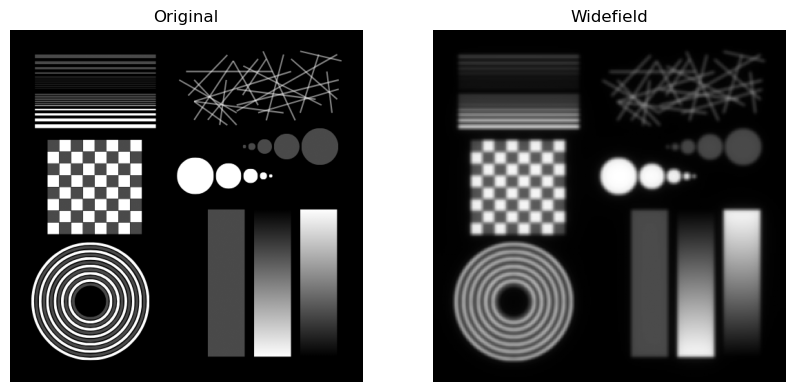

In [8]:
plt.set_cmap('gray')

synthetic = ski.img_as_float(ski.color.rgb2gray(ski.io.imread('source_images\Synthetic512.png')))

# synthetic_circles = ski.transform.resize(ski.color.rgb2gray(ski.io.imread('source_images\Synthetic_circles.png')[:, :, :3]), (512, 512), anti_aliasing=True)
# print(synthetic_circles.shape, synthetic_circles.min(), synthetic_circles.max())
# synthetic = synthetic_circles

synthetic256 = op.otf_incoherent(synthetic, NA=1.2, wavelength=680, pixelsize=100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(synthetic)
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(synthetic256)
ax[1].set_title("Widefield")
ax[1].axis('off')
plt.show()

-0.8148259745821682 5.623962655961419 0.7410517673866422
0.0 1.0 0.1904114138038062
0.0 1.0 0.24164137561345247 (256, 256)
0.18526294184666056


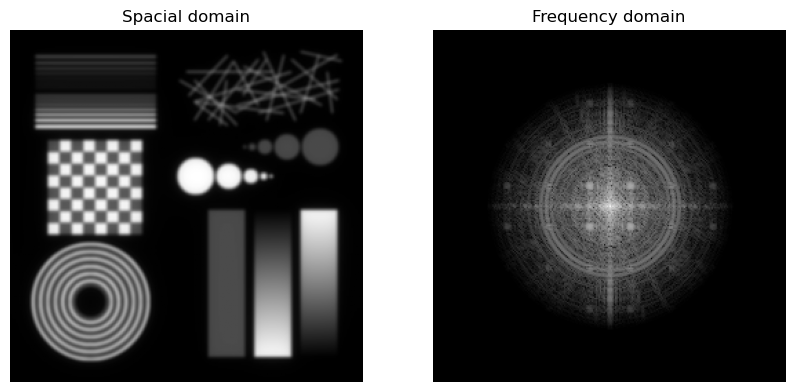

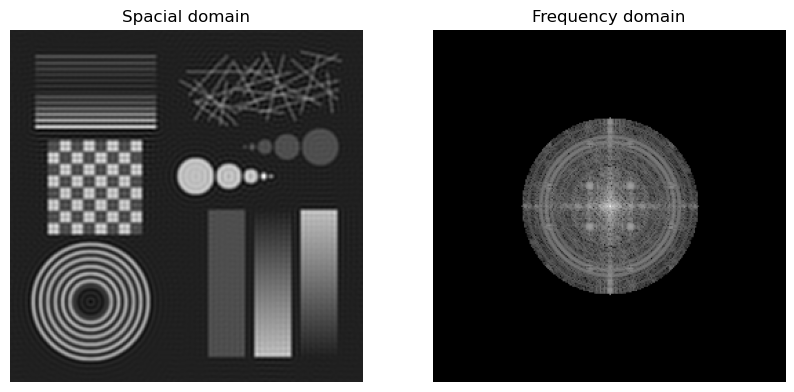

In [9]:
# Some visulaization
synthetic256circle = op.circle_lowpass(synthetic, 64)
print(synthetic256.min(), synthetic256.max(), synthetic256.mean())
synthetic256 = op.otf_incoherent(synthetic, NA=1.2, wavelength=680, pixelsize=100)
print(synthetic256circle.min(), synthetic256circle.max(), synthetic256circle.mean(), synthetic256.shape)
print(synthetic.mean())

op.display_fourier(synthetic256)
op.display_fourier(synthetic256circle)

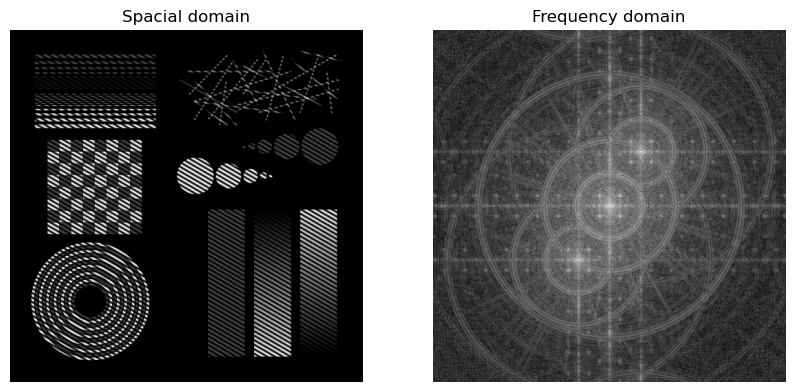

In [10]:
# Adding structured illumination
synthetic_grated = np.zeros((9, synthetic.shape[0], synthetic.shape[1]))

for i in range(3):
    for j in range(3):
        synthetic_grated[3*i + j] = synthetic * op.grating(len(synthetic), 120 * i,  120 * j, NA=1.2, wavelength=680, pixelsize=100)

op.display_fourier(synthetic_grated[3])

In [11]:
# Add noise to the images
percentage = 0.1
folder_path = 'output_images/simple_circles'
synthetic_grated_gaussian = gauss_noise(synthetic_grated, percentage)
synthetic_grated_poisson = poisson_noise(synthetic_grated, percentage)
synthetic_grated_saltpepper = salt_pepper_noise(synthetic_grated, percentage)
synthetic_grated_mix = mix_noise(synthetic_grated, percentage)

# Apply low-pass filter
synthetic_grated_gaussian_256 = op.otf_incoherent(synthetic_grated_gaussian, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_poisson_256 = op.otf_incoherent(synthetic_grated_poisson, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_saltpepper_256 = op.otf_incoherent(synthetic_grated_saltpepper, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_mix_256 = op.otf_incoherent(synthetic_grated_mix, NA=1.2, wavelength=600, pixelsize=100)


In [12]:
# Range and mean intensity
print(np.min(synthetic_grated_gaussian_256), np.max(synthetic_grated_gaussian_256), np.mean(synthetic_grated_gaussian_256))
print(np.min(synthetic_grated_poisson_256), np.max(synthetic_grated_poisson_256), np.mean(synthetic_grated_poisson_256))
print(np.min(synthetic_grated_saltpepper_256), np.max(synthetic_grated_saltpepper_256), np.mean(synthetic_grated_saltpepper_256))
print(np.min(synthetic_grated_mix_256), np.max(synthetic_grated_mix_256), np.mean(synthetic_grated_mix_256))

0.0 1.0 0.2011014637159851
0.0 1.0 0.17665956443901087
0.0 1.0 0.1852750739493128
0.0 1.0 0.18395481073194822


In [13]:
synthetic_grated_256 = op.otf_incoherent(synthetic_grated) # Ground truth
noisy_image = synthetic_grated_mix_256

noisy_PSNR = np.zeros(9)
noisy_SSIM = np.zeros(9)
for i in range(9):
    noisy_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], noisy_image[i])
    noisy_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], noisy_image[i], data_range=1)

print("Noisy PSNR: ", np.mean(noisy_PSNR))
print("Noisy SSIM: ", np.mean(noisy_SSIM))


# op.display_fourier(synthetic_grated_256[0]) # Noise free image

# Save images
# ski.io.imsave(os.path.join(folder_path, 'synthetic_grated_circle_256.tif'), synthetic_grated_256)
# ski.io.imsave(os.path.join(folder_path, 'noisy_image_256.tif'), noisy_image)

Noisy PSNR:  29.226535756389858
Noisy SSIM:  0.7618403660380916


In [14]:
# Wiener filter
psf = op.gaussian_psf(3)
wiener_synthetic_grated_256 = np.zeros((9, 256, 256))

balance = 0.00001 # 1% 0.0001

for i in range(9):
    wiener_synthetic_grated_256[i] = ski.restoration.wiener(noisy_image[i], psf, balance)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], wiener_synthetic_grated_256[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], wiener_synthetic_grated_256[i], data_range=1)
    
print("Wiener PSNR: ", np.mean(wiener_PSNR))
print("Wiener SSIM: ", np.mean(wiener_SSIM))

# Save images
# ski.io.imsave(os.path.join(folder_path, 'wiener_synthetic_grated_256.tif'), wiener_synthetic_grated_256)

Wiener PSNR:  30.36415389278729
Wiener SSIM:  0.7801784671720826


In [15]:
# Total variation filter
tv_synthetic_grated_256 = np.zeros((9, 256, 256))

weight = 0.00001 # 1% 0.0002
for i in range(9):
    tv_synthetic_grated_256[i] = ski.restoration.denoise_tv_chambolle(noisy_image[i], weight)

tv_PSNR = np.zeros(9)
tv_SSIM = np.zeros(9)

for i in range(9):
    tv_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], tv_synthetic_grated_256[i])
    tv_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], tv_synthetic_grated_256[i], data_range=1)

print("TV PSNR: ", np.mean(tv_PSNR))
print("TV SSIM: ", np.mean(tv_SSIM))

# Save images
# ski.io.imsave(os.path.join(folder_path, 'tv_synthetic_grated_256.tif'), tv_synthetic_grated_256)

TV PSNR:  29.225777499204607
TV SSIM:  0.7618176789011681


In [16]:
# BM3D filter
bm3d_synthetic_grated_256 = np.zeros((9, 256, 256))
sigma_psd = 0.01 # 1% 0.001
for i in range(9):
    bm3d_synthetic_grated_256[i] = bm3d.bm3d(noisy_image[i], sigma_psd, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

bm3d_PSNR = np.zeros(9)
bm3d_SSIM = np.zeros(9)

for i in range(9):
    bm3d_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], bm3d_synthetic_grated_256[i])
    bm3d_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], bm3d_synthetic_grated_256[i], data_range=1)

print("BM3D PSNR: ", np.mean(bm3d_PSNR))
print("BM3D SSIM: ", np.mean(bm3d_SSIM))

# Save images
# ski.io.imsave(os.path.join(folder_path, 'bm3d_synthetic_grated_256.tif'), bm3d_synthetic_grated_256)

BM3D PSNR:  29.156781187729305
BM3D SSIM:  0.7612459807264531


In [17]:
# Richardson-Lucy filter
rl_synthetic_grated_256 = np.zeros((9, 256, 256))
psf = op.gaussian_psf(3)


for i in range(9):
    rl_synthetic_grated_256[i] = ski.restoration.richardson_lucy(noisy_image[i], psf, num_iter=30)

rl_PSNR = np.zeros(9)
rl_SSIM = np.zeros(9)

for i in range(9):
    rl_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], rl_synthetic_grated_256[i])
    rl_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], rl_synthetic_grated_256[i], data_range=1)

print("RL PSNR: ", np.mean(rl_PSNR))
print("RL SSIM: ", np.mean(rl_SSIM))

# Save images
# ski.io.imsave(os.path.join(folder_path, 'rl_synthetic_grated_256.tif'), rl_synthetic_grated_256)

RL PSNR:  30.364936675189476
RL SSIM:  0.780169499490005


In [18]:
# Create a dictionary to store the data
data = {
    'Filter': ['Noisy', 'Wiener', 'TV', 'BM3D', 'RL'],
    'PSNR': [np.mean(noisy_PSNR), np.mean(wiener_PSNR), np.mean(tv_PSNR), np.mean(bm3d_PSNR), np.mean(rl_PSNR)],
    'SSIM': [np.mean(noisy_SSIM), np.mean(wiener_SSIM), np.mean(tv_SSIM), np.mean(bm3d_SSIM), np.mean(rl_SSIM)]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print("Noisy PSNR: ", np.mean(noisy_PSNR))
print("Noisy SSIM: ", np.mean(noisy_SSIM))
display(df)
# df.to_csv(os.path.join(folder_path, 'filter_results.csv'), index=False)

Noisy PSNR:  29.226535756389858
Noisy SSIM:  0.7618403660380916


,Filter,PSNR,SSIM
0,Noisy,29.226536,0.761840
1,Wiener,30.364154,0.780178
2,TV,29.225777,0.761818
3,BM3D,29.156781,0.761246
4,RL,30.364937,0.780169


In [19]:
# double filtering
# Wiener + RL filter
wiener_rl_synthetic_grated_256 = np.zeros((9, 256, 256))
psf = op.gaussian_psf(3)


for i in range(9):
    wiener_rl_synthetic_grated_256[i] = ski.restoration.richardson_lucy(wiener_synthetic_grated_256[i], psf, num_iter=30)

wiener_rl_PSNR = np.zeros(9)
wiener_rl_SSIM = np.zeros(9)

for i in range(9):
    wiener_rl_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], wiener_rl_synthetic_grated_256[i])
    wiener_rl_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], wiener_rl_synthetic_grated_256[i], data_range=1)

print("Wiener + RL PSNR: ", np.mean(wiener_rl_PSNR))
print("Wiener + RL SSIM: ", np.mean(wiener_rl_SSIM))

Wiener + RL PSNR:  30.528823924119042
Wiener + RL SSIM:  0.7882499868985542


In [20]:
# RL + Wiener filter
psf = op.gaussian_psf(3)
rl_wiener_synthetic_grated_256 = np.zeros((9, 256, 256))

balance = 0.00001 # 1% 0.0001

for i in range(9):
    rl_wiener_synthetic_grated_256[i] = ski.restoration.wiener(rl_synthetic_grated_256[i], psf, balance)

rl_wiener_PSNR = np.zeros(9)
rl_wiener_SSIM = np.zeros(9)

for i in range(9):
    rl_wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], rl_wiener_synthetic_grated_256[i])
    rl_wiener_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], rl_wiener_synthetic_grated_256[i], data_range=1)
    
print("RL + Wiener PSNR: ", np.mean(rl_wiener_PSNR))
print("RL + Wiener SSIM: ", np.mean(rl_wiener_SSIM))

RL + Wiener PSNR:  30.52874524347878
RL + Wiener SSIM:  0.7882432520410919


In [21]:
# RL + RL filter
rl_rl_synthetic_grated_256 = np.zeros((9, 256, 256))
psf = op.gaussian_psf(3)


for i in range(9):
    rl_rl_synthetic_grated_256[i] = ski.restoration.richardson_lucy(rl_synthetic_grated_256[i], psf, num_iter=30)

rl_rl_PSNR = np.zeros(9)
rl_rl_SSIM = np.zeros(9)

for i in range(9):
    rl_rl_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], rl_rl_synthetic_grated_256[i])
    rl_rl_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], rl_rl_synthetic_grated_256[i], data_range=1)

print("RL + RL PSNR: ", np.mean(rl_rl_PSNR))
print("RL + RL SSIM: ", np.mean(rl_rl_SSIM))

RL + RL PSNR:  30.528832226223813
RL + RL SSIM:  0.7882257030789104


In [22]:
# Wiener + Wiener filter
psf = op.gaussian_psf(3)
wiener_wiener_synthetic_grated_256 = np.zeros((9, 256, 256))

balance = 0.00001 # 1% 0.0001

for i in range(9):
    wiener_wiener_synthetic_grated_256[i] = ski.restoration.wiener(wiener_synthetic_grated_256[i], psf, balance)

wiener_wiener_PSNR = np.zeros(9)
wiener_wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], wiener_wiener_synthetic_grated_256[i])
    wiener_wiener_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], wiener_wiener_synthetic_grated_256[i], data_range=1)
    
print("Wiener + Wiener PSNR: ", np.mean(wiener_wiener_PSNR))
print("Wiener + Wiener SSIM: ", np.mean(wiener_wiener_SSIM))

Wiener + Wiener PSNR:  30.528560156859992
Wiener + Wiener SSIM:  0.7882651016731362


In [23]:
data1 = {
    'Filter': ['Noisy', 'Wiener', 'TV', 'BM3D', 'RL', 'Wiener + RL', 'RL + Wiener', 'RL + RL', 'Wiener + Wiener'],
    'PSNR': [np.mean(noisy_PSNR), np.mean(wiener_PSNR), np.mean(tv_PSNR), np.mean(bm3d_PSNR), np.mean(rl_PSNR), np.mean(wiener_rl_PSNR), np.mean(rl_wiener_PSNR), np.mean(rl_rl_PSNR), np.mean(wiener_wiener_PSNR)],
    'SSIM': [np.mean(noisy_SSIM), np.mean(wiener_SSIM), np.mean(tv_SSIM), np.mean(bm3d_SSIM), np.mean(rl_SSIM), np.mean(wiener_rl_SSIM), np.mean(rl_wiener_SSIM), np.mean(rl_rl_SSIM), np.mean(wiener_wiener_SSIM)],
}

# Create a DataFrame
df1 = pd.DataFrame(data1)

# Display the DataFrame
print("Noisy PSNR: ", np.mean(noisy_PSNR))
print("Noisy SSIM: ", np.mean(noisy_SSIM))
display(df1)

# Save file
# df1.to_csv(os.path.join(folder_path, 'filter_results.csv'), index=False)

Noisy PSNR:  29.226535756389858
Noisy SSIM:  0.7618403660380916


,Filter,PSNR,SSIM
0,Noisy,29.226536,0.761840
1,Wiener,30.364154,0.780178
2,TV,29.225777,0.761818
3,BM3D,29.156781,0.761246
4,RL,30.364937,0.780169
5,Wiener + RL,30.528824,0.788250
6,RL + Wiener,30.528745,0.788243
7,RL + RL,30.528832,0.788226
8,Wiener + Wiener,30.528560,0.788265


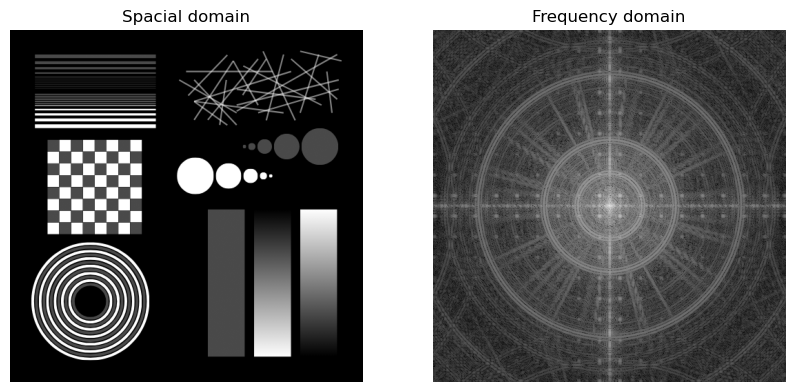

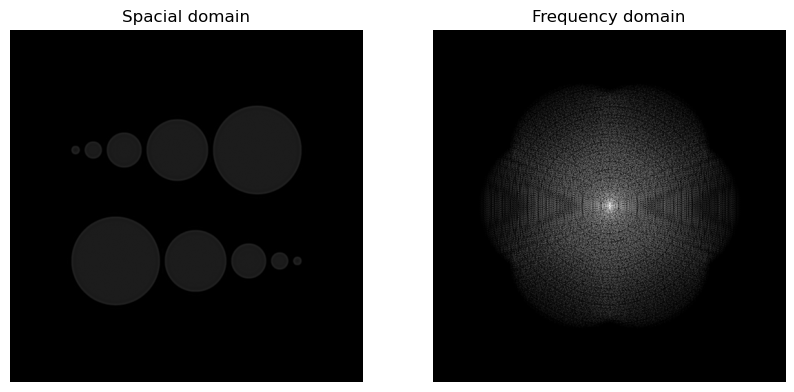

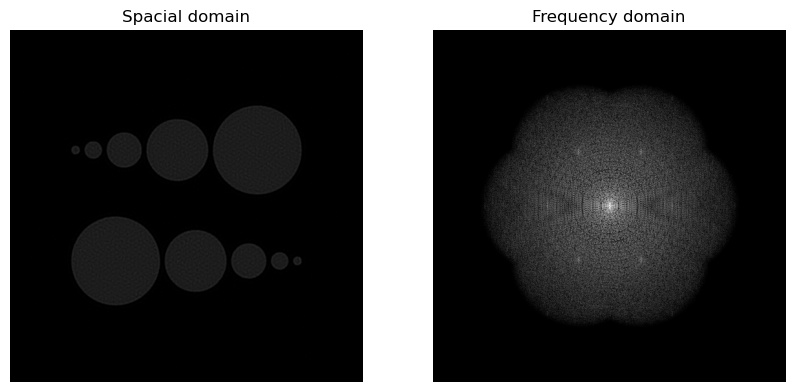

-0.038467452 0.16336823 0.020640982
-0.028502114 0.14069298 0.018705642
PSNR:  52.0680617948988
SSIM:  0.9574743428555961


In [24]:
# op.display_fourier(wiener_rl_synthetic_grated_256[5]) # Wiener + RL filtered image
# ski.io.imsave(os.path.join(folder_path, 'wiener_rl_synthetic_grated_256.tif'), wiener_rl_synthetic_grated_256)
importlib.reload(op)
original = synthetic
filtered_sim = ski.io.imread(os.path.join(folder_path, 'rl_synthetic_grated_256_sim.tif'))[:, :, 0]
noisy_sim = ski.io.imread(os.path.join(folder_path, 'noisy_image_256_sim.tif'))[:, :, 0]
metric = ski.io.imread(os.path.join(folder_path, 'synthetic_grated_circle_256_sim.tif'))[:, :, 0]


# filtered_sim = op.normalize(filtered_sim)
# metric = op.normalize(metric)
# metric = original

op.display_fourier(original)
op.display_fourier(metric)
op.display_fourier(filtered_sim)

print(filtered_sim.min(), filtered_sim.max(), filtered_sim.mean())
print(metric.min(), metric.max(), metric.mean())

psnr_value = ski.metrics.peak_signal_noise_ratio(metric, filtered_sim)
ssim_value = ski.metrics.structural_similarity(metric, filtered_sim, data_range=1)

print("PSNR: ", psnr_value)
print("SSIM: ", ssim_value)